# GeoGuessr Artificial Intelligence Model 🌏🌎🌍

In [92]:
# imports
import numpy as np
import cv2 as cv 
import os
import matplotlib.pyplot as plt

## Data Loading 📷

The used dataset is based on Google Streetview captures tagged with the latitude and longitude (geoTagged). The images are organized into folders based on the country they are taken from (the name of the folder is the country code).

This model works with the countries from Europe (from the [UN's point of view](https://www.worldometers.info/geography/how-many-countries-in-europe/))

In [12]:
europe_countries_code_list = ["AL", "AD", "AT", "BY", "BE", "BA", "BG", "HR", "CZ", "DK", "EE", "FI", "FR", "DE", "GR", "VA", "HU", "IS", "IE", "IT", "LV", "LI", "LT", "LU", "MT", "MD", "MC", "ME", "NL", "MK", "NO", "PL", "PT", "RO", "RU", "SM", "RS", "SK", "SI", "ES", "SE", "CH", "UA", "GB"]

### Data Insights
Let's take a look at the number of images in each folder.

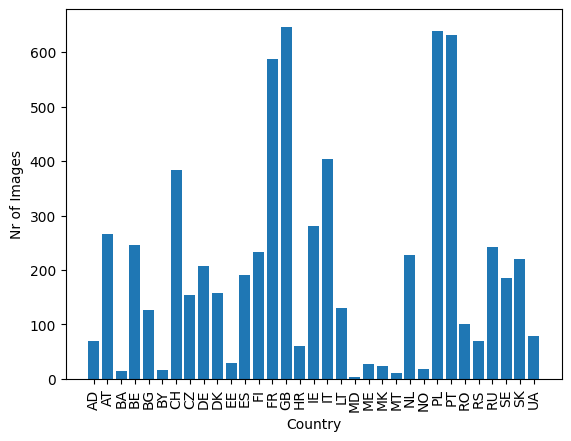

In [96]:
dataset_rel_path = "./data/geotagged_kaggle/streetviews/"
country_nr_images = {}

def count_files_in_dir(dir_path):
    return len(os.listdir(dir_path))

DATASET_ROOT_PATH = os.path.abspath(dataset_rel_path)

for country_folder in os.listdir(DATASET_ROOT_PATH):
    if (country_folder in europe_countries_code_list):
        country_nr_images[country_folder] = len(os.listdir(os.path.join(DATASET_ROOT_PATH, country_folder)))

plt.bar(country_nr_images.keys(), country_nr_images.values())
plt.xlabel("Country")
plt.xticks(rotation=90)
plt.ylabel("Nr of Images")
plt.show()